In [6]:
# ===================================================================
# BLOQUE 1: PREPARACIÓN COMPLETA DE DATOS
# ===================================================================
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# --- Carga de Datos y Feature Engineering ---
df = pd.read_csv('Students_Data.csv')
df.dropna(axis=0, inplace=True)
print("Iniciando Ingeniería de Características...")
intereses_map = {
    "C": [1, 12, 20, 53, 64, 71, 78, 85, 91, 98], 
    "H": [9, 25, 34, 41, 56, 67, 74, 80, 89, 95],
    "A": [3, 11, 21, 28, 36, 45, 50, 57, 81, 96], 
    "S": [8, 16, 23, 33, 44, 52, 62, 70, 87, 92],
    "I": [6, 19, 27, 38, 47, 54, 60, 75, 83, 97], 
    "D": [5, 14, 24, 31, 37, 48, 58, 65, 73, 84],
    "E": [17, 32, 35, 42, 49, 61, 68, 77, 88, 93]
}
aptitudes_map = {
    "C": [2, 15, 46, 51], 
    "H": [30, 63, 72, 86], 
    "A": [22, 39, 76, 82],
    "S": [4, 29, 40, 69], 
    "I": [10, 26, 59, 90],
    "D": [13, 18, 43, 66],
    "E": [7, 55, 79, 94]
}
columnas_preguntas = df.columns[0:98]
df_scores_interes = pd.DataFrame()
for area, preguntas_nums in intereses_map.items():
    cols_a_sumar = columnas_preguntas[[num - 1 for num in preguntas_nums]]
    df_scores_interes[f'puntaje_interes_{area}'] = df[cols_a_sumar].sum(axis=1)
df_scores_aptitud = pd.DataFrame()
for area, preguntas_nums in aptitudes_map.items():
    cols_a_sumar = columnas_preguntas[[num - 1 for num in preguntas_nums]]
    df_scores_aptitud[f'puntaje_aptitud_{area}'] = df[cols_a_sumar].sum(axis=1)
def calcular_deltas(row):
    puntajes_ordenados = sorted(row, reverse=True)
    if len(puntajes_ordenados) < 3: return 0, 0
    return puntajes_ordenados[0] - puntajes_ordenados[1], puntajes_ordenados[1] - puntajes_ordenados[2]
deltas_interes = df_scores_interes.apply(calcular_deltas, axis=1, result_type='expand')
df_scores_interes['delta_interes_1_2'] = deltas_interes[0]
df_scores_interes['delta_interes_2_3'] = deltas_interes[1]
deltas_aptitud = df_scores_aptitud.apply(calcular_deltas, axis=1, result_type='expand')
df_scores_aptitud['delta_aptitud_1_2'] = deltas_aptitud[0]
df_scores_aptitud['delta_aptitud_2_3'] = deltas_aptitud[1]
X_enriquecido = pd.concat([
    df[columnas_preguntas].reset_index(drop=True),
    df_scores_interes[['delta_interes_1_2', 'delta_interes_2_3']].reset_index(drop=True),
    df_scores_aptitud[['delta_aptitud_1_2', 'delta_aptitud_2_3']].reset_index(drop=True)
], axis=1)
X = X_enriquecido
target_columns = [
    'perfil_interes_1_nombre', 
    'perfil_interes_2_nombre', 
    'perfil_aptitud_1_nombre', 
    'perfil_aptitud_2_nombre'

    # 'carrera_interes_1', 
    # 'carrera_interes_2', 
    # 'carrera_interes_3', 
    # 'carrera_interes_4',
    # 'carrera_interes_5',
    # 'carrera_aptitud_1', 
    # 'carrera_aptitud_2', 
    # 'carrera_aptitud_3', 
    # 'carrera_aptitud_4', 
    # 'carrera_aptitud_5'
]
Y_textual = df[target_columns].copy()
Y_codificado = pd.DataFrame()
encoders = {}
for col in Y_textual.columns:
    le = LabelEncoder()
    Y_codificado[col] = le.fit_transform(Y_textual[col])
    encoders[col] = le
print("Variables X e Y listas.")

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y_codificado, test_size=0.2, random_state=42
)
print("Datos divididos en entrenamiento y prueba.")
print("✅ Datos divididos en conjuntos de entrenamiento y prueba.")
print(f"Dimensiones de X_train: {X_train.shape}, Dimensiones de Y_train: {Y_train.shape}")
print(f"Dimensiones de X_train: {X_test.shape}, Dimensiones de Y_train: {Y_test.shape}")

Iniciando Ingeniería de Características...
Variables X e Y listas.
Datos divididos en entrenamiento y prueba.
✅ Datos divididos en conjuntos de entrenamiento y prueba.
Dimensiones de X_train: (431, 102), Dimensiones de Y_train: (431, 4)
Dimensiones de X_train: (108, 102), Dimensiones de Y_train: (108, 4)


In [7]:
# ===================================================================
# RANDOMIZEDSEACHCV + ITERATIVESTRATIFICATION + CLASSIFIERCHAIN
# ===================================================================
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.multioutput import ClassifierChain
from sklearn.model_selection import RandomizedSearchCV
from skmultilearn.model_selection import IterativeStratification
from scipy.stats import randint, uniform
from sklearn.metrics import make_scorer, f1_score, accuracy_score, precision_score, recall_score
from sklearn.utils.class_weight import compute_sample_weight

# ==================== 1. DEFINICIÓN DE SCORERS PERSONALIZADOS ====================
def average_f1_scorer(y_true, y_pred):
    if isinstance(y_true, pd.DataFrame): y_true = y_true.to_numpy()
    if isinstance(y_pred, pd.DataFrame): y_pred = y_pred.to_numpy()
    return np.mean([f1_score(y_true[:, i], y_pred[:, i], average='weighted', zero_division=0) for i in range(y_true.shape[1])])

def average_accuracy_scorer(y_true, y_pred):
    if isinstance(y_true, pd.DataFrame): y_true = y_true.to_numpy()
    if isinstance(y_pred, pd.DataFrame): y_pred = y_pred.to_numpy()
    return np.mean([accuracy_score(y_true[:, i], y_pred[:, i]) for i in range(y_true.shape[1])])

def average_precision_scorer(y_true, y_pred):
    if isinstance(y_true, pd.DataFrame): y_true = y_true.to_numpy()
    if isinstance(y_pred, pd.DataFrame): y_pred = y_pred.to_numpy()
    return np.mean([precision_score(y_true[:, i], y_pred[:, i], average='weighted', zero_division=0) for i in range(y_true.shape[1])])

def average_recall_scorer(y_true, y_pred):
    if isinstance(y_true, pd.DataFrame): y_true = y_true.to_numpy()
    if isinstance(y_pred, pd.DataFrame): y_pred = y_pred.to_numpy()
    return np.mean([recall_score(y_true[:, i], y_pred[:, i], average='weighted', zero_division=0) for i in range(y_true.shape[1])])

# Diccionario que agrupa todos los scorers
scoring_metrics = {
    'f1': make_scorer(average_f1_scorer),
    'accuracy': make_scorer(average_accuracy_scorer),
    'precision': make_scorer(average_precision_scorer),
    'recall': make_scorer(average_recall_scorer)
}


# ==================== 2. CONFIGURACIÓN DE LA BÚSQUEDA ====================
xgb_estimator = xgb.XGBClassifier(objective='multi:softprob', use_label_encoder=False, random_state=42)
chain_model = ClassifierChain(base_estimator=xgb_estimator, random_state=42)
param_distributions = {
    'base_estimator__n_estimators': randint(100, 400),
    'base_estimator__max_depth': randint(3, 8),
    'base_estimator__learning_rate': uniform(0.01, 0.2),
    # 'base_estimator__n_estimators': randint(150, 300),
    # 'base_estimator__max_depth': randint(2, 5), # Un rango de profundidad aún más estricto
    # 'base_estimator__learning_rate': uniform(0.01, 0.1)
    'base_estimator__subsample': uniform(0.6, 0.4),
    'base_estimator__colsample_bytree': uniform(0.6, 0.4),
    # # # 'base_estimator__scale_pos_weight': uniform(1, 10) 
    # Parametros agregados ultimos :
    'base_estimator__gamma': uniform(0, 5),
    'base_estimator__reg_lambda': uniform(1, 5)
    #Otros:
    # 'base_estimator__gamma': uniform(0.5, 10), # Explora valores de gamma más altos
    # 'base_estimator__reg_lambda': uniform(1, 10), # Explora valores de L2 más altos
    # 'base_estimator__min_child_weight': randint(1, 10) # Fuerza al modelo a considerar grupos más grandes de estudiantes
}
iterative_stratification = IterativeStratification(n_splits=3, order=1)

# *** CORRECCIÓN CLAVE ***: Usamos el diccionario en 'scoring' y especificamos 'refit'
random_search = RandomizedSearchCV(
    estimator=chain_model, 
    param_distributions=param_distributions,
    n_iter=30,
    scoring=scoring_metrics,  # <-- Usamos el diccionario de métricas
    refit='f1',               # <-- Le decimos que optimice usando F1-Score
    cv=iterative_stratification,
    n_jobs=-1,
    verbose=2,
    random_state=42,
    return_train_score=False # No necesitamos los scores de entrenamiento
)

print("--- Iniciando Búsqueda Avanzada con Métricas Múltiples ---")
random_search.fit(X_train, Y_train)

# ==================== 3. MUESTRA DE RESULTADOS DETALLADOS ====================
print("\n✅ ¡Búsqueda completada con éxito!")
print("="*60)
print("La mejor combinación de hiperparámetros (optimizada por F1) es:")
print(random_search.best_params_)

# Obtenemos el índice del mejor resultado
best_index = random_search.best_index_
results = random_search.cv_results_

print("\n--- Métricas del Mejor Modelo (obtenidas con validación cruzada) ---")
print(f"  - F1-Score Promedio:      {results['mean_test_f1'][best_index]:.4f}")
print(f"  - Accuracy Promedio:      {results['mean_test_accuracy'][best_index]:.4f}")
print(f"  - Precisión Promedio:     {results['mean_test_precision'][best_index]:.4f}")
print(f"  - Recall Promedio:        {results['mean_test_recall'][best_index]:.4f}")
print("="*60)

--- Iniciando Búsqueda Avanzada con Métricas Múltiples ---
Fitting 3 folds for each of 30 candidates, totalling 90 fits


c:\Users\SAUL\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:38:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\SAUL\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:38:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



✅ ¡Búsqueda completada con éxito!
La mejor combinación de hiperparámetros (optimizada por F1) es:
{'base_estimator__colsample_bytree': 0.9208787923016158, 'base_estimator__gamma': 0.3727532183988541, 'base_estimator__learning_rate': 0.20737738732010347, 'base_estimator__max_depth': 3, 'base_estimator__n_estimators': 235, 'base_estimator__reg_lambda': 1.027610585618012, 'base_estimator__subsample': 0.9261845713819337}

--- Métricas del Mejor Modelo (obtenidas con validación cruzada) ---
  - F1-Score Promedio:      0.6788
  - Accuracy Promedio:      0.6938
  - Precisión Promedio:     0.6886
  - Recall Promedio:        0.6938


In [9]:
# ===================================================================
# MÉTRICAS
# ===================================================================
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import pandas as pd
import numpy as np

# 1. Obtener el MEJOR modelo de tu búsqueda
final_model = random_search.best_estimator_

# 2. Realizar predicciones en el conjunto de prueba
y_pred = final_model.predict(X_test)

# 3. Convertir las predicciones a un DataFrame
y_pred_df = pd.DataFrame(y_pred, columns=Y_test.columns, index=Y_test.index)

print("✅ Predicciones generadas correctamente.")
print("-" * 50)

# --- Calcular y Mostrar Métricas Detalladas ---
# Precisión Exacta (Exact Match)
exact_match_accuracy = np.mean((Y_test.values == y_pred_df.values).all(axis=1))
# a) Calcular métricas para cada etiqueta individual (Este es el enfoque correcto)
print("--- Métricas por Etiqueta (Label-based) ---")
accuracy_list = []
f1_list = []
precision_list = []
recall_list = []

for col_name in Y_test.columns:
    # Se calcula la métrica para cada columna por separado
    acc = accuracy_score(Y_test[col_name], y_pred_df[col_name])
    prec = precision_score(Y_test[col_name], y_pred_df[col_name], average='weighted', zero_division=0)
    rec = recall_score(Y_test[col_name], y_pred_df[col_name], average='weighted', zero_division=0)
    f1 = f1_score(Y_test[col_name], y_pred_df[col_name], average='weighted', zero_division=0)
    
    accuracy_list.append(acc)
    f1_list.append(f1)
    precision_list.append(prec)
    recall_list.append(rec)
    
    print(f"  - {col_name}:  Accuracy={acc:.3f}, F1-Score={f1:.3f}")

# b) Mostrar Métricas Promedio (la mejor forma de ver el rendimiento general)
print("\n--- Métricas Promedio del Modelo ---")
print(f"🎯 Precisión Exacta (Exact Match): {exact_match_accuracy:.4f} ({exact_match_accuracy * 100:.2f}%)")
print(f"Accuracy Promedio:              {np.mean(accuracy_list):.4f}")
print(f"F1-Score Promedio (Weighted):   {np.mean(f1_list):.4f}")
print(f"Precisión Promedio (Weighted):  {np.mean(precision_list):.4f}")
print(f"Recall Promedio (Weighted):     {np.mean(recall_list):.4f}")
print("=" * 50)

✅ Predicciones generadas correctamente.
--------------------------------------------------
--- Métricas por Etiqueta (Label-based) ---
  - perfil_interes_1_nombre:  Accuracy=0.815, F1-Score=0.809
  - perfil_interes_2_nombre:  Accuracy=0.602, F1-Score=0.592
  - perfil_aptitud_1_nombre:  Accuracy=0.963, F1-Score=0.961
  - perfil_aptitud_2_nombre:  Accuracy=0.843, F1-Score=0.840

--- Métricas Promedio del Modelo ---
🎯 Precisión Exacta (Exact Match): 0.4537 (45.37%)
Accuracy Promedio:              0.8056
F1-Score Promedio (Weighted):   0.8006
Precisión Promedio (Weighted):  0.8160
Recall Promedio (Weighted):     0.8056


⚙️  Calculando la Curva de Validación General del Modelo... (esto puede tardar unos minutos)
✅ Cálculo completado.


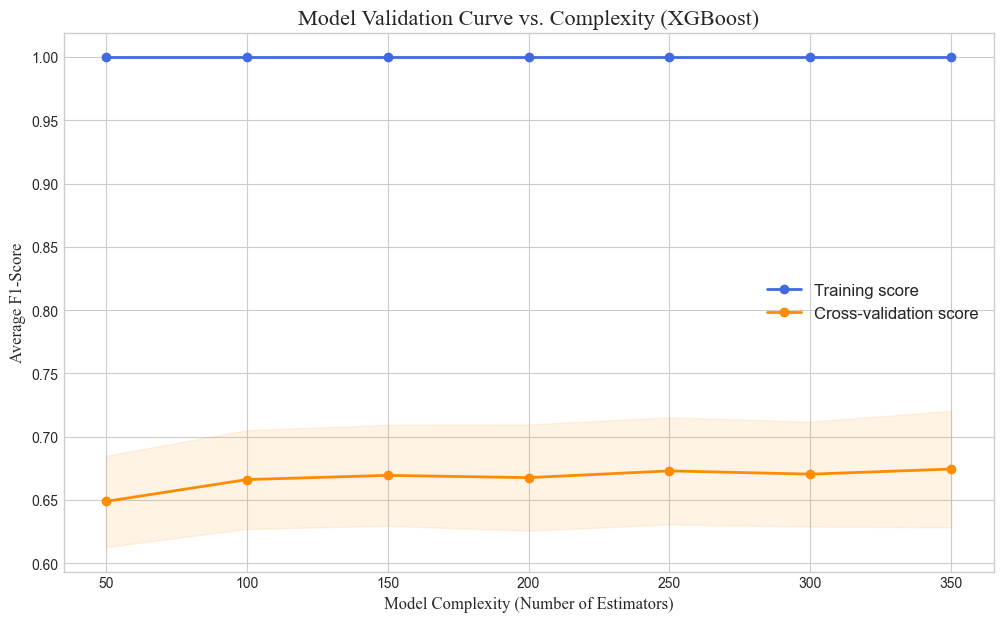

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve
from sklearn.metrics import make_scorer
from skmultilearn.model_selection import IterativeStratification

# --- 1. Preparación del Entorno ---
# Asegúrate de que tu mejor modelo de la búsqueda RandomizedSearchCV ya esté entrenado
# y disponible en la variable 'random_search'.
# También, asegúrate de tener disponible la función 'average_f1_scorer' que creaste.

# Obtenemos el mejor estimador (ClassifierChain con XGBoost)
best_model = random_search.best_estimator_

# Definimos el rango de complejidad que vamos a evaluar.
# En este caso, variaremos el número de árboles (estimadores) de XGBoost.
param_range = np.arange(50, 351, 50)  # Probaremos con 50, 100, 150, ..., 350 árboles

print("⚙️  Calculando la Curva de Validación General del Modelo... (esto puede tardar unos minutos)")

# --- 2. Cálculo de la Curva de Validación ---
# Usamos validation_curve para entrenar el modelo con diferentes valores de n_estimators
# y obtener el rendimiento promedio de las 4 etiquetas gracias a nuestro 'average_f1_scorer'.
train_scores, test_scores = validation_curve(
    estimator=best_model,
    X=X_train,
    y=Y_train,
    param_name="base_estimator__n_estimators",  # Parámetro a variar (dentro del ClassifierChain)
    param_range=param_range,
    cv=IterativeStratification(n_splits=3, order=1),  # Usamos la misma validación cruzada
    scoring=make_scorer(average_f1_scorer),         # ¡La métrica clave que promedia las 4 etiquetas!
    n_jobs=-1                                       # Usar todos los procesadores
)
print("✅ Cálculo completado.")

# --- 3. Preparación de Datos para la Gráfica ---
# Calculamos la media y la desviación estándar de los resultados
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# --- 4. Creación de la Gráfica (Estilo IJECE) ---
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 7))
plt.title("Model Validation Curve vs. Complexity (XGBoost)", fontsize=16, fontname='Times New Roman')
plt.xlabel("Model Complexity (Number of Estimators)", fontsize=12, fontname='Times New Roman')
plt.ylabel("Average F1-Score", fontsize=12, fontname='Times New Roman')

# Graficamos la línea de rendimiento del entrenamiento
plt.plot(param_range, train_scores_mean, 'o-', color="royalblue", lw=2, label="Training score")
# Graficamos la línea de rendimiento de la validación cruzada (la más importante)
plt.plot(param_range, test_scores_mean, 'o-', color="darkorange", lw=2, label="Cross-validation score")

# Añadimos las bandas de desviación estándar para un look más profesional
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="royalblue")
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="darkorange")

plt.legend(loc="best", fontsize=12)
plt.grid(True)
plt.show()

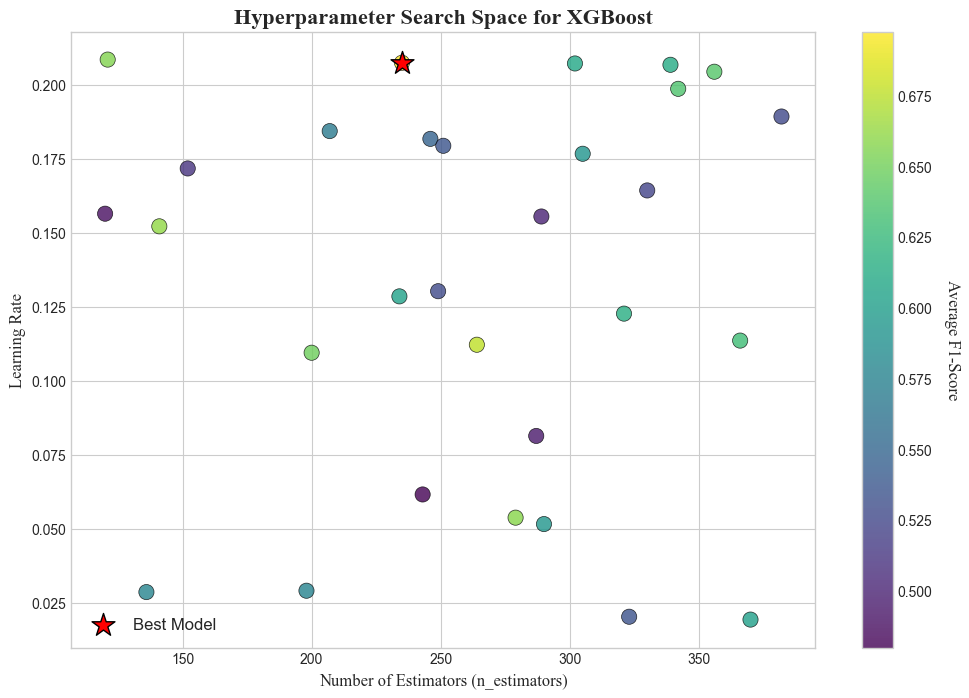

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Asumiendo que 'random_search' es tu objeto RandomizedSearchCV para XGBoost ya entrenado
results_xgb = pd.DataFrame(random_search.cv_results_)

# --- Creación de la Gráfica Profesional (Estilo IJECE) ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 8))

# El gráfico de dispersión (scatter plot)
# Eje X: n_estimators, Eje Y: learning_rate, Color: F1-Score
scatter = ax.scatter(
    results_xgb['param_base_estimator__n_estimators'], 
    results_xgb['param_base_estimator__learning_rate'], 
    c=results_xgb['mean_test_f1'], 
    cmap='viridis',  # Paleta de colores: amarillo=alto F1, azul=bajo F1
    s=120,           # Tamaño de los puntos
    alpha=0.8,
    edgecolors='k',
    linewidth=0.5
)

# Títulos y etiquetas con fuente profesional
ax.set_title('Hyperparameter Search Space for XGBoost', fontsize=16, fontname='Times New Roman', weight='bold')
ax.set_xlabel('Number of Estimators (n_estimators)', fontsize=12, fontname='Times New Roman')
ax.set_ylabel('Learning Rate', fontsize=12, fontname='Times New Roman')

# Barra de color que funciona como leyenda para el F1-Score
cbar = fig.colorbar(scatter)
cbar.set_label('Average F1-Score', rotation=270, labelpad=20, fontsize=12, fontname='Times New Roman')

# Marcar el mejor punto encontrado
best_idx = results_xgb['mean_test_f1'].idxmax()
ax.scatter(
    results_xgb['param_base_estimator__n_estimators'][best_idx],
    results_xgb['param_base_estimator__learning_rate'][best_idx],
    color='red',
    marker='*',
    s=300,
    edgecolors='black',
    label='Best Model'
)

ax.legend(fontsize=12)
plt.show()

In [ ]:
## 20 CARACTERISTICAS MÁS IMPORTANTES
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Asumiendo que 'final_model' es tu mejor modelo XGBoost (ClassifierChain) ya entrenado
# y 'X_train' es tu DataFrame de entrenamiento con los nombres de las columnas.

# --- CORRECCIÓN APLICADA ---
# Extraemos la importancia de las características de uno de los estimadores YA ENTRENADOS
# que se encuentran en la lista .estimators_ (con guion bajo)
importances = final_model.estimators_[0].feature_importances_

# Creamos un DataFrame para manejarlo y ordenarlo más fácil
feature_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importances
}).sort_values('importance', ascending=False)

# Seleccionamos las 20 características más importantes para visualizar
top_features = feature_importance_df.head(20)

# --- Creación de la Gráfica Profesional ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 10))

# Gráfico de barras horizontales
sns.barplot(x='importance', y='feature', data=top_features, palette='viridis', ax=ax)

# Títulos y etiquetas
ax.set_title('Top 20 Most Important Features (XGBoost Model)', fontsize=16, fontname='Times New Roman', weight='bold')
ax.set_xlabel('Importance Score', fontsize=12, fontname='Times New Roman')
ax.set_ylabel('Feature Name', fontsize=12, fontname='Times New Roman')

# Ajustes de diseño para una apariencia limpia
ax.tick_params(axis='y', labelsize=11)
sns.despine(left=True, bottom=True) # Remueve los bordes superior y derecho

plt.tight_layout()
plt.show()

In [7]:
from sklearn.metrics import classification_report

# Asumiendo 'final_model' es tu mejor modelo XGBoost y 'y_pred_df' son sus predicciones
print("--- Reporte de Clasificación Detallado para XGBoost ---")

for i, col in enumerate(Y_test.columns):
    print(f"\\n===== REPORTE PARA LA ETIQUETA: {col} =====")
    # Necesitas los nombres reales de las clases (ej. 'Artístico', 'Ciencias')
    # que obtienes de tus encoders: encoders[col].classes_
    target_names = encoders[col].classes_
    print(classification_report(Y_test.iloc[:, i], y_pred_df.iloc[:, i], target_names=target_names))

--- Reporte de Clasificación Detallado para XGBoost ---
\n===== REPORTE PARA LA ETIQUETA: perfil_interes_1_nombre =====
                                  precision    recall  f1-score   support

     Administrativas y Contables       0.88      0.93      0.90        15
                      Artísticas       0.83      0.65      0.73        23
     Ciencias Exactas y Agrarias       1.00      0.64      0.78        11
             Defensa y Seguridad       0.78      0.58      0.67        12
Humanísticas y Ciencias Sociales       0.80      0.93      0.86        30
        Ingeniería y Computación       0.00      0.00      0.00         0
 Medicina y Ciencias de la Salud       0.73      0.94      0.82        17

                        accuracy                           0.81       108
                       macro avg       0.72      0.67      0.68       108
                    weighted avg       0.82      0.81      0.80       108

\n===== REPORTE PARA LA ETIQUETA: perfil_interes_2_nombre =====

c:\Users\SAUL\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\SAUL\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\SAUL\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

In [8]:
from sklearn.metrics import confusion_matrix
import pandas as pd

# 1. Crea un diccionario con tus modelos finales
models_to_analyze = {
    'XGBoost': final_model, # Asume que final_model es tu XGBoost
    # 'Random Forest': final_rf_model,
    # 'SVM': final_svm_model,
    # 'Regresión Logística': final_lr_model
}

# 2. Bucle principal para analizar cada modelo
for model_name, model in models_to_analyze.items():
    print(f"\\n===== ANALIZANDO ERRORES PARA: {model_name} =====")
    
    # Realizar predicciones para el modelo actual
    y_pred = model.predict(X_test)
    y_pred_df = pd.DataFrame(y_pred, columns=Y_test.columns)
    
    # Lista para guardar todos los errores de este modelo
    model_errors = []
    
    # Iterar sobre cada una de las 4 etiquetas
    for i in range(Y_test.shape[1]):
        label_name = Y_test.columns[i]
        class_names = encoders[label_name].classes_
        
        cm = confusion_matrix(Y_test.iloc[:, i], y_pred_df.iloc[:, i])
        
        # Extraer los errores (fuera de la diagonal principal)
        for true_idx in range(len(class_names)):
            for pred_idx in range(len(class_names)):
                if true_idx != pred_idx and cm[true_idx, pred_idx] > 0:
                    true_class = class_names[true_idx]
                    pred_class = class_names[pred_idx]
                    error_count = cm[true_idx, pred_idx]
                    
                    error_description = f"`{label_name}`: Real '{true_class}' ➡️ Predicho '{pred_class}'"
                    model_errors.append((error_count, error_description))
    
    # 3. Ordenar los errores de mayor a menor y mostrar los 3 principales
    model_errors.sort(key=lambda x: x[0], reverse=True)
    
    print("Top 3 Confusiones:")
    for count, description in model_errors[:3]:
        print(f"- {description} (N° de Instancias: {count})")

\n===== ANALIZANDO ERRORES PARA: XGBoost =====
Top 3 Confusiones:
- `perfil_interes_2_nombre`: Real 'Administrativas y Contables' ➡️ Predicho 'Artísticas' (N° de Instancias: 5)
- `perfil_interes_2_nombre`: Real 'Artísticas' ➡️ Predicho 'Humanísticas y Ciencias Sociales' (N° de Instancias: 5)
- `perfil_interes_2_nombre`: Real 'Humanísticas y Ciencias Sociales' ➡️ Predicho 'Artísticas' (N° de Instancias: 5)


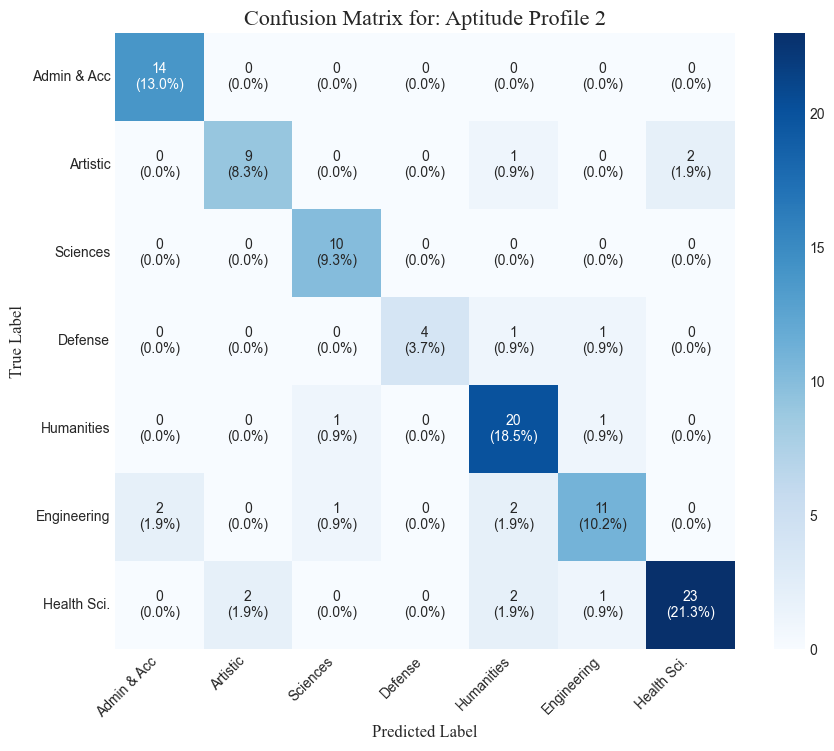

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# ===================================================================
# PREREQUISITES:
# This code assumes the following variables already exist from your previous cells:
# - Y_test: DataFrame with the true labels for the test set.
# - y_pred_df: DataFrame with the predicted labels from your model.
# - encoders: Dictionary of your fitted LabelEncoders.
# ===================================================================

# --- CONFIGURATION: CHANGE THIS NUMBER FOR EACH LABEL (0, 1, 2, or 3) ---
LABEL_TO_PLOT = 3
# --------------------------------------------------------------------
column_name_translation = {
    'perfil_interes_1_nombre': 'Interest Profile 1',
    'perfil_interes_2_nombre': 'Interest Profile 2',
    'perfil_aptitud_1_nombre': 'Aptitude Profile 1',
    'perfil_aptitud_2_nombre': 'Aptitude Profile 2'
}

# Select the specified label to plot
column_to_plot = Y_test.columns[LABEL_TO_PLOT]
true_labels = Y_test[column_to_plot]
pred_labels = y_pred_df[column_to_plot]

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
class_names = encoders[column_to_plot].classes_

# Abbreviation map for cleaner labels
abbreviation_map = {
    'Humanísticas y Ciencias Sociales': 'Humanities',
    'Administrativas y Contables': 'Admin & Acc',
    'Defensa y Seguridad': 'Defense',
    'Ciencias Exactas y Agrarias': 'Sciences',
    'Ingeniería y Computación': 'Engineering',
    'Artísticas': 'Artistic',
    'Medicina y Ciencias de la Salud': 'Health Sci.'
}
abbreviated_names = [abbreviation_map.get(name, name) for name in class_names]

# Create custom annotations (count and percentage)
group_counts = [f"{value}" for value in cm.flatten()]
total_samples = np.sum(cm)
group_percentages = [f"{value/total_samples:.1%}" for value in cm.flatten()]
annotations = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]
annotations = np.asarray(annotations).reshape(cm.shape)

# Plotting
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=annotations, fmt='', cmap='Blues',
            xticklabels=abbreviated_names, yticklabels=abbreviated_names, cbar=True)

translated_column = column_name_translation.get(column_to_plot, column_to_plot)

plt.title(f'Confusion Matrix for: {translated_column}', fontsize=16, fontname='Times New Roman')
plt.ylabel('True Label', fontsize=12, fontname='Times New Roman')
plt.xlabel('Predicted Label', fontsize=12, fontname='Times New Roman')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

C:\Users\SAUL\AppData\Local\Temp\ipykernel_10216\2320008428.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=error_counts, y=error_descs, palette='viridis', ax=ax)


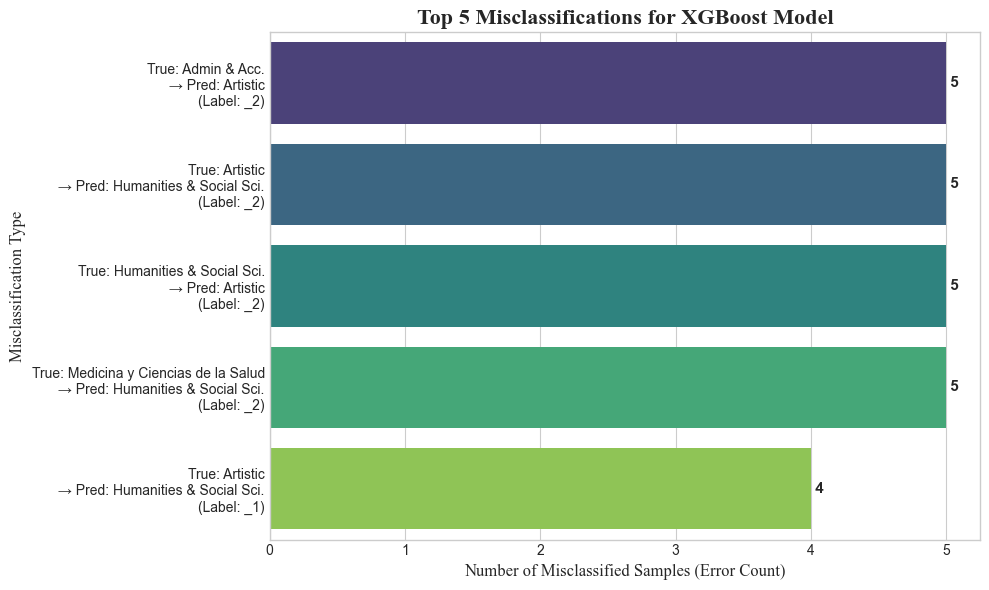

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

# ===================================================================
# PREREQUISITES:
# This code assumes the following variables already exist from your previous cells:
# - Y_test: DataFrame with the true labels for the test set.
# - y_pred_df: DataFrame with the predicted labels from the model you are analyzing.
# - encoders: Dictionary of your fitted LabelEncoders.
# ===================================================================

# ===== PASO CLAVE: Diccionario de Traducción (Español a Inglés) =====
translation_map = {
    'Humanísticas y Ciencias Sociales': 'Humanities & Social Sci.',
    'Administrativas y Contables': 'Admin & Acc.',
    'Defensa y Seguridad': 'Defense & Security',
    'Ciencias Exactas y Agrarias': 'Exact & Agrarian Sci.',
    'Ingeniería y Computación': 'Engineering & Computing',
    'Artísticas': 'Artistic',
    'Medicina y ciencias de la Salud': 'Medicine & Health Sci.' 
}
# =====================================================================


# --- 1. Extract All Misclassifications from the Model ---
model_errors = []
for i, col_name in enumerate(Y_test.columns):
    # Asegúrate de que y_pred_df corresponda al modelo que estás analizando
    cm = confusion_matrix(Y_test[col_name], y_pred_df[col_name]) 
    class_names = encoders[col_name].classes_
    
    # Iterar sobre la matriz de confusión para encontrar los errores
    for true_idx in range(len(class_names)):
        for pred_idx in range(len(class_names)):
            if true_idx != pred_idx and cm[true_idx, pred_idx] > 0:
                true_class_spanish = class_names[true_idx]
                pred_class_spanish = class_names[pred_idx]
                error_count = cm[true_idx, pred_idx]
                
                # ===== Usamos el diccionario para traducir los nombres =====
                true_class_english = translation_map.get(true_class_spanish, true_class_spanish)
                pred_class_english = translation_map.get(pred_class_spanish, pred_class_spanish)
                
                # Formatear la descripción del error con los nombres en inglés
                error_description = f"True: {true_class_english}\n→ Pred: {pred_class_english}\n(Label: {col_name[-9:-7]})"
                model_errors.append((error_count, error_description))

# --- 2. Preparar los datos para la gráfica ---
# Ordenar los errores por frecuencia y obtener el Top 5
model_errors.sort(key=lambda x: x[0], reverse=True)
top_5_errors = model_errors[:5]

# Separar conteos y descripciones para graficar
error_counts = [count for count, desc in top_5_errors]
error_descs = [desc for count, desc in top_5_errors]

# --- 3. Generar el Gráfico de Barras ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 6))

# Crear el gráfico de barras horizontales
sns.barplot(x=error_counts, y=error_descs, palette='viridis', ax=ax)

# Títulos y etiquetas en inglés
ax.set_title('Top 5 Misclassifications for XGBoost Model', fontsize=16, fontname='Times New Roman', weight='bold')
ax.set_xlabel('Number of Misclassified Samples (Error Count)', fontsize=12, fontname='Times New Roman')
ax.set_ylabel('Misclassification Type', fontsize=12, fontname='Times New Roman')

# Añadir el conteo al final de cada barra para mayor claridad
for index, value in enumerate(error_counts):
    ax.text(value, index, f' {value}', va='center', fontsize=11, weight='bold')

plt.tight_layout()
plt.show()